# Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Importing the Dataset

In [2]:
df = pd.read_csv("./notebook/data/stud.csv")
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


# Model Development

Our main target is to predict the score in mathematics based on other variables

In [3]:
## Choosing the right dependent and independent variable

### Independent Variables
X = df.drop(labels = ["math_score"], axis = 1)
print(f"Independent Variables: \n\n{X.head()}\n")
print("-"*50)

## Dependent Variables
y = df["math_score"]
print(f"Dependent Variables: \n\n{y.head()}\n")

Independent Variables: 

   gender race_ethnicity parental_level_of_education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test_preparation_course  reading_score  writing_score  
0                    none             72             74  
1               completed             90             88  
2                    none             95             93  
3                    none             57             44  
4                    none             78             75  

--------------------------------------------------
Dependent Variables: 

0    72
1    69
2    90
3    47
4    76
Name: math_score, dtype: int64



## Using Sentence Transformer for Embedding

In [4]:
# !pip install -U -q sentence-transformers

In [5]:
X.columns

Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course', 'reading_score', 'writing_score'],
      dtype='object')

In [6]:
from sentence_transformers import SentenceTransformer
## Creating a compiler to rearrange the data to feed into transformers

def compile_text(x):
    text = f"""
    gender: {x['gender']},
    race_ethnicity: {x['race_ethnicity']},
    parental_level_of_education: {x['parental_level_of_education']},
    lunch: {x['lunch']},
    test_preparation_course: {x['test_preparation_course']},
    reading_score: {x['reading_score']},
    writing_score: {x['writing_score']}
    """
    return text
    

In [7]:
sentences = df.apply(lambda x: compile_text(x), axis = 1).tolist()
sentences[:5]

["\n    gender: female,\n    race_ethnicity: group B,\n    parental_level_of_education: bachelor's degree,\n    lunch: standard,\n    test_preparation_course: none,\n    reading_score: 72,\n    writing_score: 74\n    ",
 '\n    gender: female,\n    race_ethnicity: group C,\n    parental_level_of_education: some college,\n    lunch: standard,\n    test_preparation_course: completed,\n    reading_score: 90,\n    writing_score: 88\n    ',
 "\n    gender: female,\n    race_ethnicity: group B,\n    parental_level_of_education: master's degree,\n    lunch: standard,\n    test_preparation_course: none,\n    reading_score: 95,\n    writing_score: 93\n    ",
 "\n    gender: male,\n    race_ethnicity: group A,\n    parental_level_of_education: associate's degree,\n    lunch: free/reduced,\n    test_preparation_course: none,\n    reading_score: 57,\n    writing_score: 44\n    ",
 '\n    gender: male,\n    race_ethnicity: group C,\n    parental_level_of_education: some college,\n    lunch: standar

## Embedding the Sentences

In [8]:
model = SentenceTransformer(model_name_or_path = "sentence-transformers/paraphrase-MiniLM-L12-v2")
output = model.encode(sentences = sentences, 
                      show_progress_bar = True, 
                      normalize_embeddings = True)
df_embedding = pd.DataFrame(output)
df_embedding.head()
                            

E:\Anaconda\envs\end2end\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.119227,-0.021076,-0.015102,0.081490,-0.001118,0.014785,-0.007801,-0.025423,-0.047808,0.023593,...,-0.020315,0.014668,0.058611,0.024760,-0.002074,0.019595,0.111144,0.049568,-0.046184,0.010407
1,0.138447,-0.021206,0.023071,0.071404,-0.041350,-0.006856,0.003891,-0.030456,-0.033563,0.040233,...,-0.010179,0.024058,0.049314,0.010737,-0.011787,0.029593,0.090023,0.054721,-0.071039,0.032930
2,0.106297,-0.012690,-0.000158,0.080546,-0.019611,0.012331,-0.004579,-0.042357,-0.039717,0.026542,...,-0.015073,0.020475,0.068723,0.008067,0.002924,0.015728,0.102491,0.038366,-0.054335,0.019648
3,0.118638,0.009926,-0.024721,0.082673,-0.016803,0.024724,-0.009318,-0.056415,-0.036331,0.017350,...,-0.001049,0.005137,0.044682,0.032673,-0.025557,0.017226,0.116619,0.056950,-0.061059,0.018570
4,0.124627,-0.020872,-0.004680,0.056003,-0.027196,-0.002091,0.002747,-0.025764,-0.042340,0.028849,...,-0.007161,0.023064,0.052045,0.027404,-0.004773,0.004554,0.106605,0.052091,-0.054387,0.025878


## Using PCA and Gridsearch Cv to reduce the dimension

In [9]:
## Based on the above result: best number of pca components = 30
pca = PCA(n_components = 30)
pca_comps = pca.fit_transform(df_embedding)
pca_df = pd.DataFrame(pca_comps)
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.025845,-0.130847,0.064361,-0.010958,0.035584,0.023766,0.045543,0.019518,0.048348,0.045893,...,0.015208,-0.003621,0.007681,0.018631,-0.001747,-0.011367,0.004375,0.008441,0.000795,0.002592
1,-0.152655,0.012797,-0.119085,-0.112315,0.037748,0.048039,-0.014859,0.001142,0.041836,-0.018959,...,-0.010655,-0.004945,-0.003786,-0.000694,0.008302,0.011243,-0.000233,0.010711,0.017982,0.010634
2,-0.036369,-0.108001,0.040202,-0.010129,0.039701,0.003529,0.048290,0.021819,0.074453,-0.007337,...,0.003684,-0.005503,0.018204,-0.005675,0.014905,0.002520,-0.001553,-0.025419,0.003183,0.016965
3,0.155809,-0.070533,0.010446,0.056208,-0.067766,0.008691,0.002753,-0.011344,-0.018914,-0.065788,...,-0.017173,-0.005710,-0.014318,-0.001695,0.014136,-0.003398,0.004485,-0.007123,0.012267,0.002022
4,-0.025771,-0.001464,0.056866,-0.110559,-0.033391,0.050126,-0.084230,0.038989,0.029623,0.006364,...,0.001187,-0.007704,0.000873,0.003598,0.008749,0.004663,0.012567,0.000216,-0.004029,0.000411


## Splitting the dataset into train and test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size = 0.20, random_state = 7, shuffle = True)
print(X_train.shape, X_test.shape)

(800, 30) (200, 30)


## Selecting the right model

### Importing Several Models

In [11]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [12]:
models = {
    "Ridge":Ridge(),
    "Lasso": Lasso(),
    "RFR": RandomForestRegressor(),
    "DTR": DecisionTreeRegressor(),
    "SVR": SVR()
}


## Defining the hyperparameters grid

params_grid = {
    "Ridge": {'alpha': [1, 2, 4, 6, 8]},
    "Lasso": {'alpha': [1, 2, 4, 6, 8]},
    "RFR": {'n_estimators': [50, 100, 120, 150, 200],'max_depth': [5, 10, 15, 20]},
    "DTR": {'max_depth': [5, 10, 15, 20]},
    "SVR": {'kernel': ['rbf', 'poly'], 'degree': [3, 5, 7], 'gamma': ['scale', 'auto']}
}


def perform_grid_search_cv(model:dict, param_grid: dict, x_test, y_test):
    best_model = {}

    for model_name, model in model.items():
        print(f"Performing Grid Search for {model_name}")
        grid_search = GridSearchCV(estimator = model, param_grid = params_grid[model_name], scoring = "r2", n_jobs = -1, cv = 5)
        grid_search.fit(x_test, y_test)
        best_model[model_name] = grid_search.best_estimator_
        print(f"Best Parameters for {model_name} is {grid_search.best_params_}")
        print("-"*50)
            
    return best_model

## Finding the best model
best_models = perform_grid_search_cv(models, params_grid, X_test, y_test)



Performing Grid Search for Ridge
Best Parameters for Ridge is {'alpha': 1}
--------------------------------------------------
Performing Grid Search for Lasso
Best Parameters for Lasso is {'alpha': 1}
--------------------------------------------------
Performing Grid Search for RFR
Best Parameters for RFR is {'max_depth': 10, 'n_estimators': 100}
--------------------------------------------------
Performing Grid Search for DTR
Best Parameters for DTR is {'max_depth': 20}
--------------------------------------------------
Performing Grid Search for SVR
Best Parameters for SVR is {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
--------------------------------------------------


In [13]:
## Evaluate the best model

for model_name, model in best_models.items():
    y_pred = model.predict(X_train)
    mean_squared = mean_squared_error(y_train, y_pred)
    print(f"MSE of {model_name} is {mean_squared}")
    print("-"*10)

MSE of Ridge is 152.42683139134442
----------
MSE of Lasso is 240.6711549774185
----------
MSE of RFR is 113.6882656383148
----------
MSE of DTR is 209.5225
----------
MSE of SVR is 183.90950731891732
----------


**From the above analysis, the best estimator would be Random Forest Regressor with 'max_depth': 20, 'n_estimators': 50**

## Training the Model

In [14]:
## Model Training
model = RandomForestRegressor(max_depth = 20, n_estimators = 50)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=50)

In [15]:
## Checking models prediction on train and test dataset
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f"MSE on train dataset:{mean_squared_error(y_train, y_pred_train)}")
print(f"MSE on test dataset:{mean_squared_error(y_test, y_pred_test)}")

MSE on train dataset:10.092832273333334
MSE on test dataset:74.31662605555556


### Plotting Actual and Predicted

In [16]:
residuals = y_train - y_pred_train

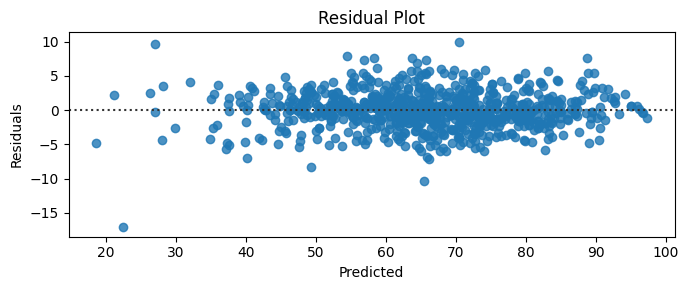

In [17]:
plt.figure(figsize = (7,3))
plt.subplot(111)
sns.residplot(x = y_pred_train, y = residuals, line_kws={'color': 'red', 'lw': 1})
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()

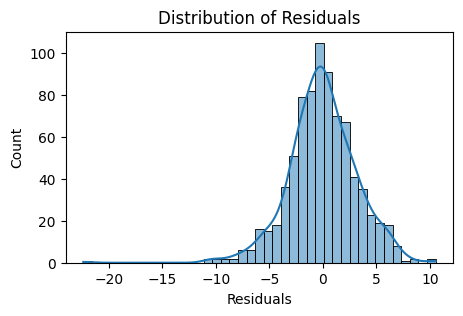

In [18]:
plt.figure(figsize=(5, 3))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

**Insights**
* Most of the predictions are deviated by +/-5 from the true value.

In [22]:
pd.DataFrame(data = {"y_test": y_test, "y_pred_test": y_pred_test}).sample(10)

,y_test,y_pred_test
347,77,69.76
705,62,68.58
713,81,88.06
676,73,66.26
491,64,62.00
125,87,82.60
74,49,62.32
365,49,58.54
693,77,66.18
801,76,85.34
